# Spectral Line Problem
This is the example discussed in Sections 3.6-3.8 of Gregory that shows you how to do parameter estimation and model selection in the Bayesian formalism.  It is a somewhat simplified version of the type of problem commonly faced in the natural sciences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The data are shown in Table 3.1 and consists of the measured signal strength (in units of mK) as a function of the channel number that runs from 1-64.  I have imported (by hand!) the data into a text file `SpectralLine.dat`, which has 2 columns - channel number and signal strength.

In [2]:
# numpy's genfromtxt loads structured ASCII data into an array
data1   = np.genfromtxt('SpectralLine1.dat')
channel = data1[:, 0]
signal  = data1[:, 1]

Plot the data and you can see that it is identical to Figure 3.3 of Gregory.  It is noisy, but not too uncommon for Nobel-worthy experiments!

Text(0, 0.5, 'signal strength (mK)')

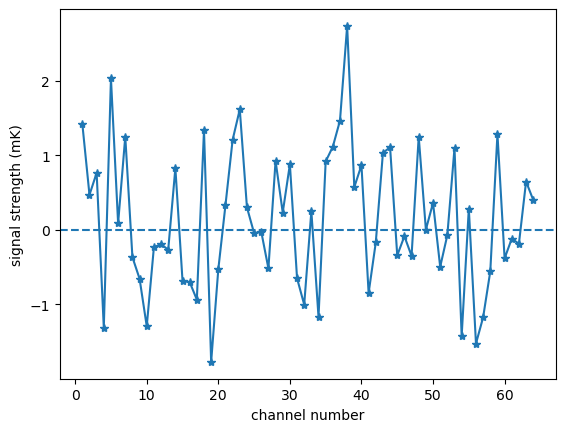

In [3]:
plt.plot(channel, signal, marker='*')
plt.axhline(y=0, linestyle="--")
plt.xlabel("channel number")
plt.ylabel("signal strength (mK)")

We want to investigate two competing models.  Model 1 consists of a gaussian-shaped signal and Model 2 predicts no signal (zeros across the channels).  Model 1 predicts the gaussian signal to be centered on channel 37 with a gaussian width of 2.0.  In other words the predicted signal $S$(model 1) of Model 1 is: $$S\mathrm{(model~1)} = T~e^{-(\nu_i-\nu_0)^2/(2\sigma_L^2)} = T~f_i$$ where $T$ is a free parameter that corresponds to the amplitude (height) of the gaussian, $\sigma_L$ is its intrinsic width, $\nu_0$ is its central channel, and $\nu_i$ is the channel number.  Model 2, on the other hand, does not contain the gaussian, so $$S\mathrm{(model~2)} = 0$$ for all values of $\nu_i$.  Let's define both models as functions.

In [4]:
def model1(nu, T, nu0=37.0, sigL=2.0):
    S = T*np.exp(-((nu-nu0)**2)/(2*sigL*sigL))
    return S

In [5]:
def model2(nu):
    S = np.zeros_like(nu)  # because we want all the values for each nu
    # S = 0.0*nu           # this should also work
    return S

Let's plot them on a finer grid of channel number just so we can see the full details of the models.

In [6]:
testchannel = np.arange(1, 64.1, 0.1)
testmodel1  = model1(testchannel, 1.0)  # Here, I am taking the amplitude T=1.0
testmodel2  = model2(testchannel)

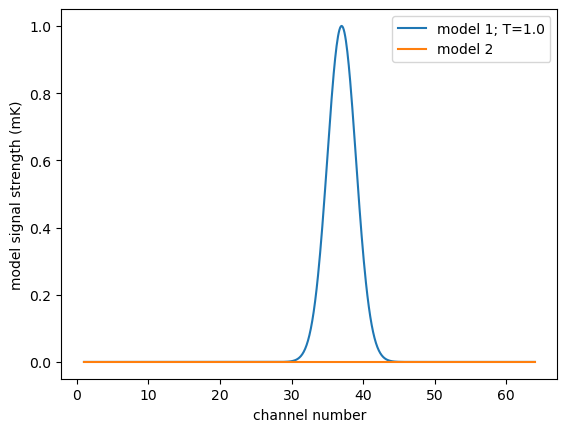

In [7]:
plt.plot(testchannel, testmodel1, label='model 1; T=1.0')
plt.plot(testchannel, testmodel2, label='model 2')
#plt.axhline(y=0, linestyle="--")
plt.xlabel("channel number")
plt.ylabel("model signal strength (mK)")
plt.legend()

Given the data and model, we can now compute the likelihood, the probability of the data given the model.  We assume that the measurement device can measure the signal with a gaussian distribution centered on the signal and an uncertainty of $\sigma = 1.0$ mK in each channel independently.  In other words, if the expected signal is given by $S_i$ in channel $\nu_i$, the probability of measuring a particular signal value of $d_i$ in that channel is given by $$p(d_i|T, M_1, I) = \frac{1}{\sigma\sqrt{2\pi}}~e^{-(d_i-S_i)^2/(2\sigma^2)}.$$  Then the probability of measuring the set of $D = {d_1, d_2, ... d_N}$ is the product $$p(D|T, M_1, I) = \prod_{i=1}^{N=64} p(d_i|T, M_1, I) = \left( \frac{1}{\sigma\sqrt{2\pi}} \right)^N~e^{-\sum_i(d_i-S_i)^2/(2\sigma^2)} = \mathcal{L}.$$  This is the likelihood of our data given the model with parameter $T$.

In [8]:
def logLikelihood(data, model, sig=1.0):
    # This function computes the natural logarithm of the likelihood given by the above
    # equation.  We commonly use ln(L) because L is often a very small number
    # and difficult to deal with on a computer.  The maximum of L occurs at the same T
    # value as the maximum of ln(L).
    N = len(data)
    logL = -(np.sum((data-model)**2))/(2*sig*sig) - (N/2)*np.log(2*np.pi) - N*np.log(sig)
    return logL

Noramlly, you would have search for the value of the parameter(s) that maximizes the likelihood.  In this case, it's rather simple since there is only one free parameter.  We will do this later, but let's go ahead and trust our friend Gregory who tells us that the value of $T$ that maximizes the likelihood is $T_{ml} = 1.561$ (mK) with $L = 8.520 \times 10^{-37}$.  Let's verify this value.

Also note from the expression above that maximizing log(L) is equivalent to minimizing the sum of (data-model)^2.  This is where the term "least squares" comes from.

In [9]:
Tml = 1.561
modelMaxL  = model1(channel, Tml)           # compute the model for T=Tml
maxL1 = logLikelihood(signal, modelMaxL)    # and then its likelihood value
print("max ln(L) = ", maxL1)
print("    max L = ", np.exp(maxL1))

max ln(L) =  -83.05324483203903
    max L =  8.519891523193788e-37


Now let's look at two forms of the prior discussed in the book.  The first one is a uniform prior, which has a constant value $$p(T|M_1, I) = \frac{1}{T_{\mathrm{max}} - T_{\mathrm{min}}}$$ between $T_{\mathrm{min}}$ and $T_{\mathrm{max}}$.  The other prior is called the Jeffreys prior, which represents equal probability per decade.  The normalized expression for the Jeffreys prior is $$p(T|M_1, I) = \frac{1}{T\ln(T_{\mathrm{max}}/T_{\mathrm{min}})}.$$ The book continues to apply these priors in the range $0.1 \le T \le 100$ (mK).

In [10]:
def priorUniform(T, Tmin=0.1, Tmax=100.0):
    prior = (T/T)*1.0/(Tmax-Tmin)
    return prior

In [11]:
def priorJeffreys(T, Tmin=0.1, Tmax=100.0):
    prior = 1.0/(T*np.log(Tmax/Tmin))
    return prior

Let's just see what these priors look like vs T.  Compare with Figure 3.4 of Gregory.

In [12]:
testsignal = np.arange(0.1, 100, 0.1)
testprior1 = priorUniform(testsignal)
testprior2 = priorJeffreys(testsignal)

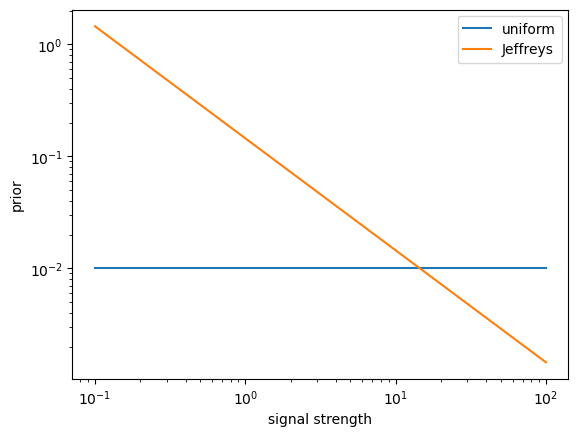

In [13]:
plt.plot(testsignal, testprior1, label='uniform')
plt.plot(testsignal, testprior2, label='Jeffreys')
#plt.axhline(y=0, linestyle="--")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("signal strength")
plt.ylabel("prior")
plt.legend()

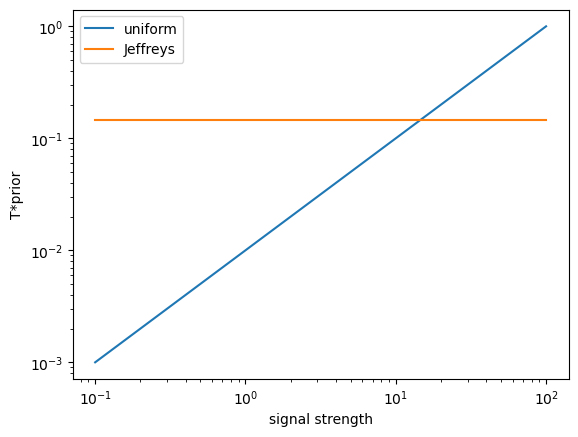

In [14]:
plt.plot(testsignal, testsignal*testprior1, label='uniform')
plt.plot(testsignal, testsignal*testprior2, label='Jeffreys')
#plt.axhline(y=0, linestyle="--")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("signal strength")
plt.ylabel("T*prior")
plt.legend()

Let's overplot the data and the maximum-likelihood model.

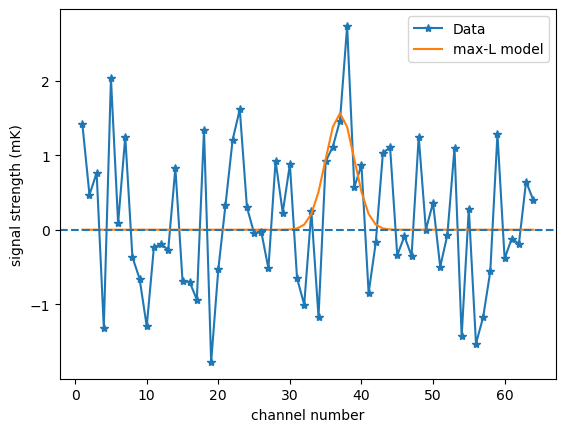

In [15]:
plt.plot(channel, signal, marker='*', label='Data')
plt.plot(channel, modelMaxL, label='max-L model')
plt.axhline(y=0, linestyle="--")
plt.xlabel("channel number")
plt.ylabel("signal strength (mK)")
plt.legend()

Let's check that the maximum likelihood actually occurs at $T=1.561$ (mK).  This is technically an optimization problem (searching for min/max of functions), but since we have only a single parameter (T), we can just plot the likelihood vs T and look for the maximum.  Below, I create a grid of $T$ values and compute $\ln{L}$ on that grid.

In [16]:
Trange = np.arange(0.1, 100, 0.01)
logL   = np.empty_like(Trange)
for i, t in enumerate(Trange):
    modelTmp = model1(channel, t)
    logL[i] = logLikelihood(signal, modelTmp)

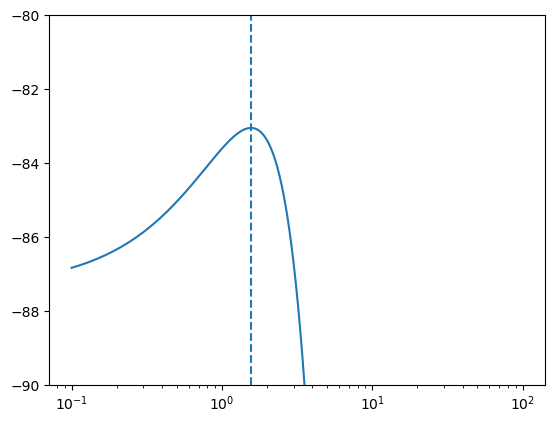

In [17]:
plt.plot(Trange, logL)
plt.xscale('log')
plt.ylim([-90, -80])
plt.axvline(x=1.571, linestyle="--")

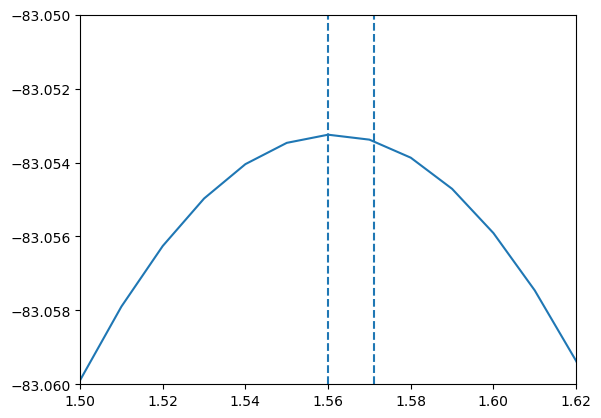

In [18]:
plt.plot(Trange, logL)
plt.xlim([1.5,1.62])
plt.ylim([-83.06, -83.05])
plt.axvline(x=1.571, linestyle="--")
plt.axvline(x=1.560, linestyle="--")  # not quite at 1.571?

The log likelihood indeed does peak near that value.  Later in the semester, we will learn how to compute the maximum likelihood parameters for arbitrary models.  It turns out that if the model is linear in the parameters such as this case, there is an analytic solution for the parameters and their uncertainties.

We now have the prior and likelihood.  If we ignore the normalization constant (but we will caluculate it below where we compute the odds ratio), we can calculate the quantity proportional to the posterior.  Compare with Figure 3.6 of Gregory.

In [19]:
def logPosterior(prior, logL, norm):
    return np.log(prior) + logL - np.log(norm)

Text(0, 0.5, 'unnormalized $p(T|D,M_1,I)$')

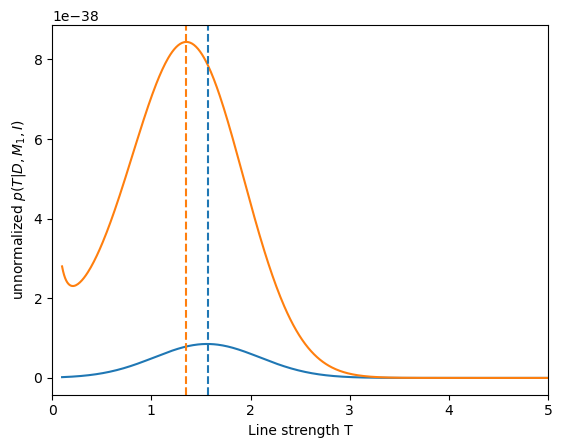

In [20]:
priorU = priorUniform(Trange)
priorJ = priorJeffreys(Trange)
plt.plot(Trange, np.exp(logPosterior(priorU, logL, 1.0)))
plt.plot(Trange, np.exp(logPosterior(priorJ, logL, 1.0)))
plt.xlim([0, 5])
plt.axvline(x=1.571, linestyle="--", color='#1f77b4')
plt.axvline(x=1.350, linestyle="--", color='#ff7f0e')
plt.xlabel('Line strength T')
plt.ylabel('unnormalized $p(T|D,M_1,I)$')

Note the slightly different maximum posterior locations: $T=1.57$ mK for uniform and $T=1.35$ mK for Jeffreys.

# Model Selection

Now let's perform model selection between model 1 (gaussian line) and model 2 (no line).  To do this, we compute the odds ratio given by: $$O_{12} = \frac{p(M_1|D,I)}{p(M_2|D,I)} = \frac{p(M_1|I)p(D|M_1,I)}{p(M_2|I)p(D|M_2,I)} = \frac{p(M_1|I)}{p(M_2|I)}B_{ij}.$$  $p(D|M_1,I)$ involves an integral over its parameter $T$ (marginalization), $$p(D|M_1,I) = \int p(T|M_1,I)p(D|T,M_1,I) dT.$$  We already have the functions for the two terms in the integrand, so it is simple to perform the numerical integration.  There are multiple `scipy.integrate` methods described below.  We will use `trapezoid`.

https://docs.scipy.org/doc/scipy/tutorial/integrate.html

In [21]:
from scipy import integrate

In [22]:
def marginalize(Tgrid, prior, logL):
    answer  = integrate.trapezoid(prior*np.exp(logL), Tgrid)
    # this simple numpy integrator works just as well
    # answer  = np.trapz(prior*np.exp(logL), Tgrid)
    return answer

In [23]:
pM1U = marginalize(Trange, priorU, logL)
pM1J = marginalize(Trange, priorJ, logL)
print("p(D|M_1,I) = %10.3e" % pM1U, " for uniform prior")
print("p(D|M_1,I) = %10.3e" % pM1J, " for Jeffreys prior")

p(D|M_1,I) =  1.132e-38  for uniform prior
p(D|M_1,I) =  1.239e-37  for Jeffreys prior


We now have the proper normalization constants, so we can plot the normalized posterior PDFs.  Compare with Figure 3.6 of Gregory.

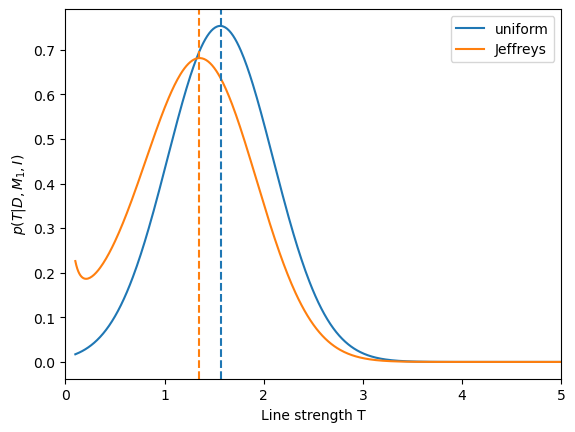

In [24]:
plt.plot(Trange, np.exp(logPosterior(priorU, logL, pM1U)), label='uniform')
plt.plot(Trange, np.exp(logPosterior(priorJ, logL, pM1J)), label='Jeffreys')
plt.xlim([0, 5])
plt.axvline(x=1.571, linestyle="--", color='#1f77b4')
plt.axvline(x=1.350, linestyle="--", color='#ff7f0e')
plt.xlabel('Line strength T')
plt.ylabel('$p(T|D,M_1,I)$')
plt.legend()

Now let's calculate $p(D|M_2,I)$ so we can compute the odds ratio.  The choice of prior doesn't matter here because $M_2$ doesn't depend on $T$.

In [25]:
logL2  = np.empty_like(Trange)
for i, t in enumerate(Trange):
    modelTmp = model2(channel)
    logL2[i] = logLikelihood(signal, modelTmp)

In [26]:
pM2U = marginalize(Trange, priorU, logL2)
pM2J = marginalize(Trange, priorJ, logL2)
print("p(D|M_2,I) = %10.3e" % pM2U, " for uniform prior")
print("p(D|M_2,I) = %10.3e" % pM2J, " for Jeffreys prior")

p(D|M_2,I) =  1.133e-38  for uniform prior
p(D|M_2,I) =  1.133e-38  for Jeffreys prior


In [27]:
oddsU = pM1U/pM2U
oddsJ = pM1J/pM2J
print("O_12 = %10.3e" % oddsU, " for uniform prior")
print("O_12 = %10.3e" % oddsJ, " for Jeffreys prior")

O_12 =  9.994e-01  for uniform prior
O_12 =  1.094e+01  for Jeffreys prior


These odds ratios are much too low to claim a discovery and the Nobel Prize!

# Simulations

Let's simulate a dataset that looks like the one shown in the left panel of Figure 3.7 in Gregory, which has a much higher line strength than our previous example.  We can do this by sampling from a hypothetical model using line strength $T = 5$ mK (Figure 3.7; right panel) and the same $\sigma = 1$ mK as before.

In [28]:
newmodel = model1(channel, 5.0)

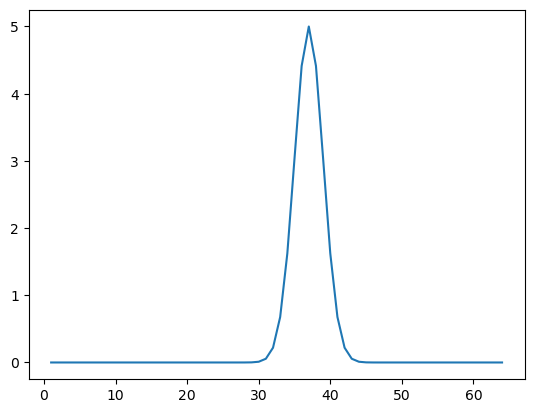

In [29]:
plt.plot(channel, newmodel)

For each channel, sample the signal from a gaussian distribution with mean equal to the model and $\sigma = 1.0$ mK.  I am setting the random seed here for repeatability.

In [30]:
np.random.seed(239847)
newsignal = np.random.normal(newmodel, scale=1.0)

Text(0, 0.5, 'signal strength (mK)')

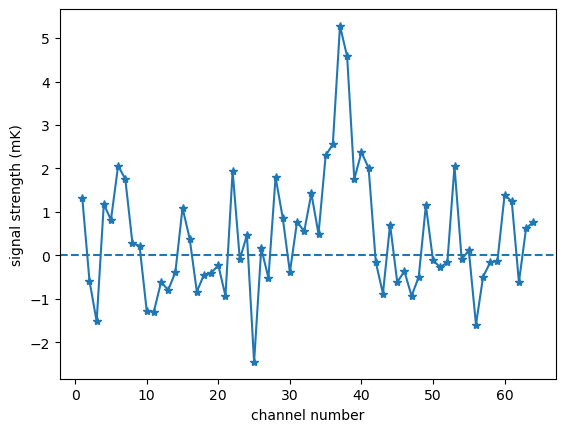

In [31]:
plt.plot(channel, newsignal, marker='*')
plt.axhline(y=0, linestyle="--")
plt.xlabel("channel number")
plt.ylabel("signal strength (mK)")

The plot above looks qualitatively similar to Figure 3.7 left panel.

Next, calculate the likelihood function $p(T|D^\prime, M_1, I)$.

In [32]:
logLnew  = np.empty_like(Trange)
for i, t in enumerate(Trange):
    modelTmp = model1(channel, t)
    logLnew[i] = logLikelihood(newsignal, modelTmp)

And the normalization constants.

In [33]:
pM1U = marginalize(Trange, priorU, logLnew)
pM1J = marginalize(Trange, priorJ, logLnew)
print("p(D|M_1,I) = %10.3e" % pM1U, " for uniform prior")
print("p(D|M_1,I) = %10.3e" % pM1J, " for Jeffreys prior")

p(D|M_1,I) =  1.567e-41  for uniform prior
p(D|M_1,I) =  5.283e-41  for Jeffreys prior


Similarly for Model 2, which has no spectral line.

In [34]:
logL2new  = np.empty_like(Trange)
for i, t in enumerate(Trange):
    modelTmp = model2(channel)
    logL2new[i] = logLikelihood(newsignal, modelTmp)

In [35]:
pM2U = marginalize(Trange, priorU, logL2new)
pM2J = marginalize(Trange, priorJ, logL2new)
print("p(D|M_2,I) = %10.3e" % pM2U, " for uniform prior")
print("p(D|M_2,I) = %10.3e" % pM2J, " for Jeffreys prior")

p(D|M_2,I) =  2.910e-54  for uniform prior
p(D|M_2,I) =  2.910e-54  for Jeffreys prior


And the odds ratios.

In [36]:
oddsU = pM1U/pM2U
oddsJ = pM1J/pM2J
print("O_12 = %12.5e" % oddsU, "for uniform prior")
print("O_12 = %12.5e" % oddsJ, "for Jeffreys prior")

O_12 =  5.38487e+12 for uniform prior
O_12 =  1.81526e+13 for Jeffreys prior


Note the much larger odds ratio for this higher-signal data.  The data clearly favors Model 1 with the spectral line by a large margin.

Finally, the normalized posterior PDFs for $T$. Compare with Figure 3.7 right panel.  Given that the signal is much stronger, the final PDF is not too sensitive on the form of the prior, as expected.

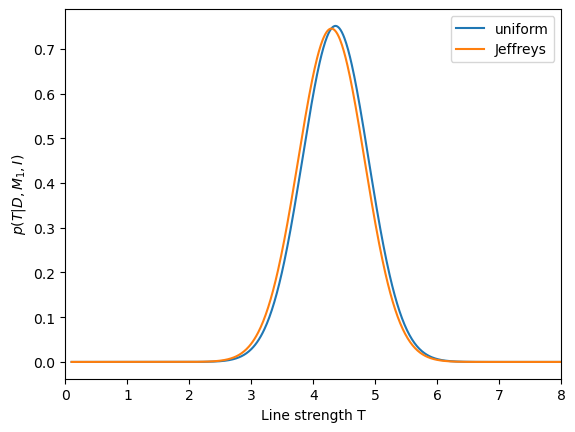

In [37]:
plt.plot(Trange, np.exp(logPosterior(priorU, logLnew, pM1U)), label="uniform")
plt.plot(Trange, np.exp(logPosterior(priorJ, logLnew, pM1J)), label="Jeffreys")
plt.xlim([0, 8])
#plt.axvline(x=4.37, linestyle="--", color='#1f77b4')
#plt.axvline(x=4.27, linestyle="--", color='#ff7f0e')
plt.xlabel('Line strength T')
plt.ylabel('$p(T|D,M_1,I)$')
plt.legend()